In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [3]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


In [4]:
layer.weights

[<tf.Variable 'kernel:0' shape=(4, 3) dtype=float32, numpy=
 array([[ 0.26294076,  0.39575255,  0.23577964],
        [-0.65597194,  0.7481799 ,  0.47631872],
        [ 0.81091774, -0.33585143,  0.6644633 ],
        [ 0.5304973 ,  0.15933919, -0.823305  ]], dtype=float32)>,
 <tf.Variable 'bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [5]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


In [6]:
layer.weights

[<tf.Variable 'gamma:0' shape=(4,) dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>,
 <tf.Variable 'beta:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'moving_mean:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'moving_variance:0' shape=(4,) dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>]

In [7]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


## The typical transfer-learning workflow
**This leads us to how a typical transfer learning workflow can be implemented in Keras:**

- Instantiate a base model and load pre-trained weights into it.
- Freeze all layers in the base model by setting trainable = False.
- Create a new model on top of the output of one (or several) layers from the base model.
- Train your new model on your new dataset.


**Note that an alternative, more lightweight workflow could also be:**

- Instantiate a base model and load pre-trained weights into it.
- Run your new dataset through it and record the output of one (or several) layers from the base model. This is called feature extraction.
- Use that output as input data for a new, smaller model.m

In [8]:
import tensorflow as af
import keras
import numpy as np

Using TensorFlow backend.


In [9]:
base_model = keras.applications.Xception(weights='imagenet', input_shape=(150, 150, 3), include_top=False)

In [10]:
# freezing the trainable of weight of base model
base_model.trainable = False

In [11]:
# creating a new model on the top
# We make sure that the base_model is running in inference mode here,by passing `training=False`.
# This is important for fine-tuning, as you will learn in a few paragraphs.

# Convert features of shape `base_model.output_shape[1:]` to vectors
# A Dense classifier with a single unit (binary classification)

inputs = keras.Input(shape=(150, 150, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

TypeError: call() got an unexpected keyword argument 'training'

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)

In [ ]:
# fine tufning the wohle base model
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes to the `trainable` attribute of any inner layer,
# so that your changes are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)

In [ ]:
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

## hands on example

In [116]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

tf.keras.backend.clear_session()

In [118]:
batch_size = 16
train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is a generator that will read pictures found in subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

Found 2000 images belonging to 2 classes.


In [119]:
train_generator[0][0].shape

(16, 150, 150, 3)

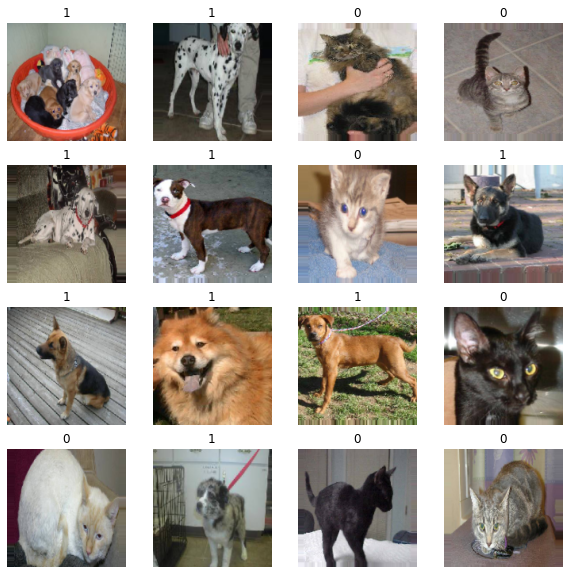

In [120]:
image , label = train_generator[0]
i = 0
plt.figure(figsize=(10,10))
i = 1
for img in image:
    ax = plt.subplot(4,4,i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(int(label[i-1]))
    i+=1

In [121]:
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 800 images belonging to 2 classes.


In [122]:
# this is the augmentation configuration we will use for testing: only rescaling
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)



# this is a similar generator, for validation data
test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 700 images belonging to 2 classes.


In [123]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)
base_model.trainable = False


inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [124]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
# model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

In [125]:
model.fit_generator(
        train_generator,
#         steps_per_epoch=2000 // batch_size,
#         epochs=20,
#         validation_data=validation_generator,
#         validation_steps=800 // batch_size
        )
# model.save_weights('first_try.h5')  # always save your weights after training or during training

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]